In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
#allocs = pd.Series([.3, .3, .35, .05, 1], index=['ES','NQ', 'GC', 'CL', 'total'])
allocs = pd.Series([.5, .5, 1], index=['ES','NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/blotter/blotter_2020-03-15_21-15_week_6.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [4]:
df.groupby('contract').realizedPNL.sum()

contract
CL    6381.04
ES   -9841.80
GC   -1187.12
NQ   -5306.80
Name: realizedPNL, dtype: float64

In [5]:
df.realizedPNL.sum()

-9954.68

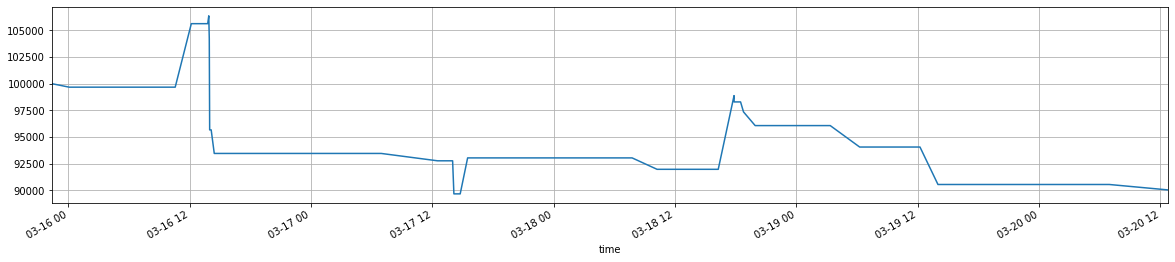

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL     8
ES     5
GC    18
NQ     4
Name: action, dtype: int64

In [9]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    18.96
ES    21.00
GC    87.12
NQ    16.80
Name: commission, dtype: float64

In [10]:
df.commission.sum()

143.88000000000002

In [11]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
CL,0.50,1595.26,3820.26,-629.74,6.07,1595.26,4.0
GC,0.22,-131.90,4660.32,-1501.11,3.10,-145.60,9.0
ES,0.00,-4920.90,NaN,-4920.90,NaN,NaN,2.0
NQ,0.00,-2653.40,NaN,-2653.40,NaN,NaN,2.0
total,0.24,-585.57,4240.29,-2070.45,2.05,-555.87,17.0


In [12]:
by_contract.resample('B').sum()

contract,CL,ES,GC,NQ,total
time,,,,,
2020-03-13 00:00:00+00:00,0.00,0.0,0.00,0.0,0.00
2020-03-16 00:00:00+00:00,410.52,-8558.4,3820.64,-2208.4,-6535.64
2020-03-17 00:00:00+00:00,0.00,0.0,2680.64,-3098.4,-417.76
2020-03-18 00:00:00+00:00,5970.52,-1283.4,-1659.36,0.0,3027.76
2020-03-19 00:00:00+00:00,0.00,0.0,-5519.36,0.0,-5519.36
2020-03-20 00:00:00+00:00,0.00,0.0,-509.68,0.0,-509.68


In [13]:
by_contract.resample('B').sum() / (allocs * cash)

,CL,ES,GC,NQ,total
time,,,,,
2020-03-13 00:00:00+00:00,NaN,0.000000,NaN,0.000000,0.000000
2020-03-16 00:00:00+00:00,NaN,-0.171168,NaN,-0.044168,-0.065356
2020-03-17 00:00:00+00:00,NaN,0.000000,NaN,-0.061968,-0.004178
2020-03-18 00:00:00+00:00,NaN,-0.025668,NaN,0.000000,0.030278
2020-03-19 00:00:00+00:00,NaN,0.000000,NaN,0.000000,-0.055194
2020-03-20 00:00:00+00:00,NaN,0.000000,NaN,0.000000,-0.005097


In [14]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [15]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,CL,ES,GC,NQ,total
CL,NaN,NaN,NaN,NaN,NaN
ES,NaN,1.000000,NaN,0.423852,0.586578
GC,NaN,NaN,NaN,NaN,NaN
NQ,NaN,0.423852,NaN,1.000000,0.267186
total,NaN,0.586578,NaN,0.267186,1.000000


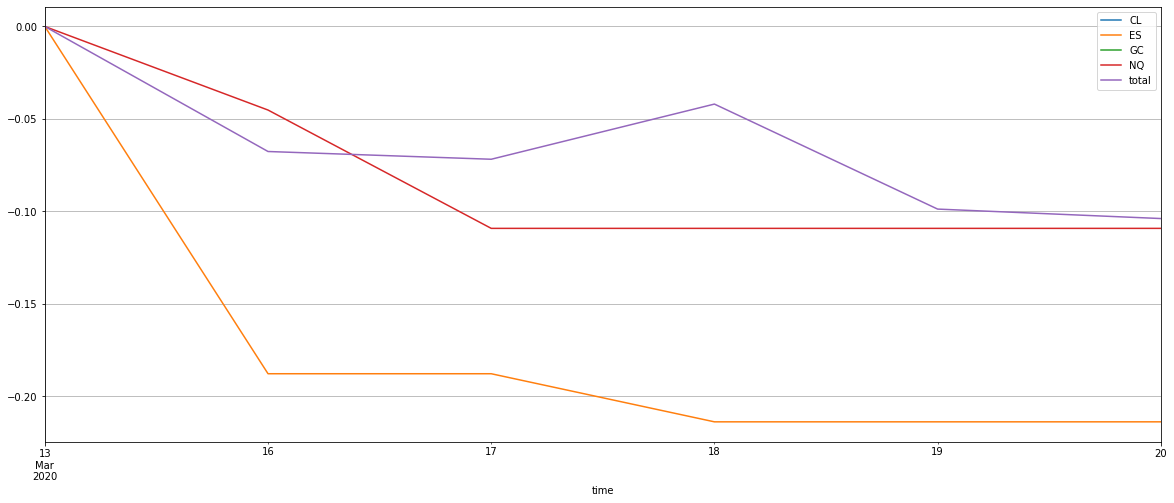

In [16]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

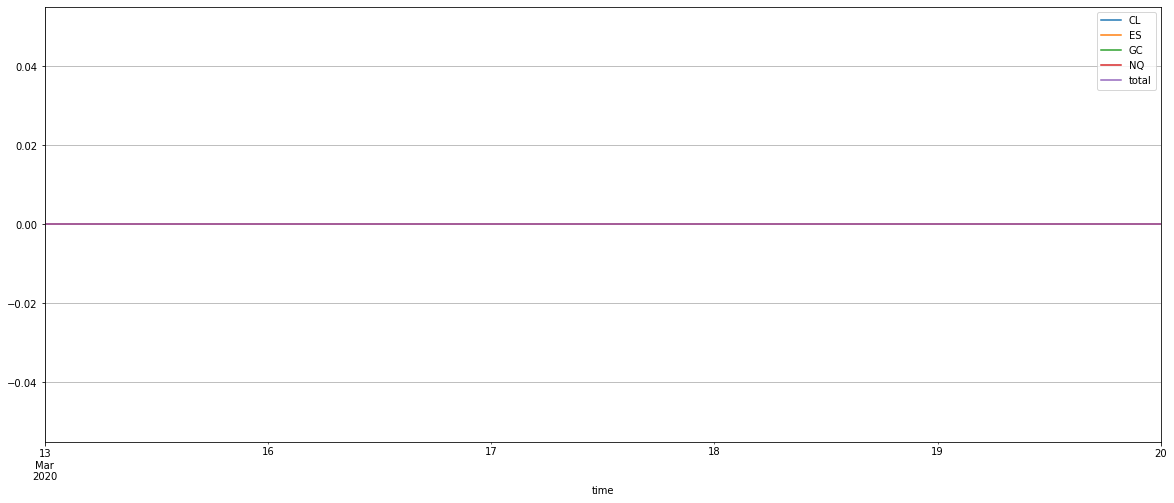

In [17]:
returns = daily
returns.iloc[0] = (daily.iloc[0] * (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [18]:
daily

,CL,ES,GC,NQ,total
time,,,,,
2020-03-13 00:00:00+00:00,NaN,-1.000000,NaN,-1.000000,-1.000000
2020-03-16 00:00:00+00:00,NaN,-0.171168,NaN,-0.044168,-0.065356
2020-03-17 00:00:00+00:00,NaN,0.000000,NaN,-0.061968,-0.004178
2020-03-18 00:00:00+00:00,NaN,-0.025668,NaN,0.000000,0.030278
2020-03-19 00:00:00+00:00,NaN,0.000000,NaN,0.000000,-0.055194
2020-03-20 00:00:00+00:00,NaN,0.000000,NaN,0.000000,-0.005097


In [19]:
returns=daily

In [20]:
returns

,CL,ES,GC,NQ,total
time,,,,,
2020-03-13 00:00:00+00:00,NaN,-1.000000,NaN,-1.000000,-1.000000
2020-03-16 00:00:00+00:00,NaN,-0.171168,NaN,-0.044168,-0.065356
2020-03-17 00:00:00+00:00,NaN,0.000000,NaN,-0.061968,-0.004178
2020-03-18 00:00:00+00:00,NaN,-0.025668,NaN,0.000000,0.030278
2020-03-19 00:00:00+00:00,NaN,0.000000,NaN,0.000000,-0.055194
2020-03-20 00:00:00+00:00,NaN,0.000000,NaN,0.000000,-0.005097


In [21]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

ValueError: Inputs must not be empty.

In [ ]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

In [ ]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

In [ ]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]